<a id='top'></a>

# Data Science Project
## Clyrical | Basic Architecture 



##### Marissa Montano



---
**Shortcuts:**  [Dependencies](#dep) | [Helper Functions](#hlp) | [Hypertune](#hyp) | [Analysis](#anal) |

---


#### Why do you care?



   The goal of our project is to classify each songs genre by lyrical content. We will be using a kaggle dataset from Gyanendra Mishra (https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics/data) and we will be using the python Sklearn library to actually help us process the data. We want to see what main communities of songs are out there, and what themes/topics and genres usually group together. Hopefully we can find out if most artists fall victim to following a generic “lyrical genre formula” when it comes to writing music.


   The methods and techniques we have been using to use to cluster these lyrics are term frequency-inverse document frequency (TF-IDF), word embeddings (Word2vec), singular value decomposition (SVD), K-Means Clustering, Spectral Clustering, Gaussian Mixture Models, K-Nearest Neighbors(KNN), and a Neural Network (NN). We are going to compare two the method of extracting the lyrics to a feature vector (ie. with mapping or embedding) using TF-IDF and Word2vec, then we are going going to (potentially) use the SVD  or PAC reduction method (we might have to reduce our dimensions if our laptops don't have the processing power to cluster with all features), we are going to compare the two clustering methods:K-Means Clustering, Spectral Clustering, against two classification methods: K-nearest, and NN. lastly we are going to try to grab common topics from the classification using LDA.


   The goal from this project is to work with natural language processing (NLP). We could have analyzed data from Spotify and just clustered based off of musical measurements like valence, but that seems like a trivial task. We feel like we would get more out of this project this semester if we analyzed the content of the songs (lyrics) instead.
   
   Hypertune the neural network with gridSearchCV.


<a id='dep'>
    
[Back to top](#top)

# Dependencies:

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import multiprocessing

#clustering
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

#vectorizing
from nltk.tokenize import sent_tokenize, word_tokenize 
from gensim.models import Word2Vec # pip install gensim==3.4.0
from gensim.models.doc2vec import Doc2Vec,  TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#reduction
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize 
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marissa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Marissa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<a id='hlp'>
    
[Back to top](#top)

# Helper Functions:

In [2]:
def preprocess(lyrics):
    # Ignore case
    lyrics = lyrics.lower()
    
    # Remove ',!?:. \n
    lyrics = ''.join([word.strip(",!?:") for word in lyrics])
    lyrics = lyrics.replace('\n', ' ')
    lyrics = lyrics.replace('\'', '')
    
    # Remove everything between hard brackets
    lyrics = re.sub(pattern="[\(\[].*?[\)\]]", repl='', string=lyrics)

    # Remove x4 and (x4), for example
    lyrics = re.sub(pattern="(\()?x\d+(\))?", repl=' ', string=lyrics)
    lyrics = lyrics.replace('  ', ' ')
    
    #remove stop words
    lyrics = [w for w in lyrics.split() if not w in stopwords.words('english')] 
    
    #return list of words
    return " ".join(lyrics), lyrics

In [3]:
def loadData(file_name, sub_list=False):
    df = pd.read_csv(file_name)
    df.dropna(inplace=True)
    if sub_list == True:
        #import only 1000 data points because my laptop SUCKS
        df = df.head(5000)
    # Clean data
    df = df.dropna()
    #drop Other, Not Avalible 
    df.drop( df[ df['genre'] == 'Other' ].index , inplace=True)
    df.drop( df[ df['genre'] == 'Not Available' ].index , inplace=True)
    df.drop( df[ df['genre'] == 'Alkebulan' ].index , inplace=True) 

    for i, row in df.iterrows():
        sentense, words = preprocess(df.loc[i,'lyrics'])
        df.loc[i,'lyrics'] = sentense
        df.loc[i, 'tag'] = TaggedDocument(words=words, tags=[df.loc[i, 'song']+str(i)])

    X_train, X_test, y_train, y_test = train_test_split(df.drop(['genre'], axis=1), df['genre'], test_size=0.20, random_state=42)
    
    return (X_train, X_test, y_train, y_test)

In [4]:
def dataExploration(x_df, y_df):
    
    genre_counts = y_df.value_counts()
    labels = list(genre_counts.index)
    count = list(x_df["lyrics"].apply(lambda x: len(x)))
    bwp = [[],[],[],[],[],[],[],[],[],[]]
    for i, gen in enumerate(y_df):
        bwp[labels.index(gen)].append(count[i])
        
    fig, ax = plt.subplots(2, figsize=(15,15))
    # create pie graph of number of songs per genre
    ax[0].pie(genre_counts.values, labels = genre_counts.index, autopct='%1.0f%%')
    # create box plot of number of lyrics
    ax[1].boxplot(bwp, labels=labels)
    plt.show()



In [5]:
# first comparsion between tfidf/w2v and spectral and k means
def clusterComparison(X_train, X_test, y_train, y_test, n_comp): 
    #params
    n_components = n_comp
    n_clusters = y_train.nunique()
    
     # TFIDF | turn lyrics to vectors
    tfidf = TfidfVectorizer(stop_words = 'english')
    X_tfidf_train = tfidf.fit_transform(X_train['lyrics'])
    X_tfidf_test = tfidf.transform(X_test['lyrics'])
    
    # Word2Vec Doc2vec | turn lyrics to vectors
    min_word_count = 3
    num_workers = multiprocessing.cpu_count()
    model = Doc2Vec(X_train['tag'].tolist(), workers=num_workers)
    X_w2v_train = model.docvecs.vectors_docs
    model = Doc2Vec(X_test['tag'].tolist(), workers=num_workers)
    X_w2v_test = model.docvecs.vectors_docs

    
    # SVD | dimension reduction
    #svd = TruncatedSVD(n_components=n_components, random_state = 0)
    #X_final = svd.fit_transform(X)
    
    # clusters
    kmeans_tf = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans_wv = KMeans(n_clusters=n_clusters, random_state=0)
    spectral_tf = SpectralClustering(n_clusters=n_clusters, random_state=0)
    spectral_wv = SpectralClustering(n_clusters=n_clusters, random_state=0)
    models_tf = [kmeans_tf, spectral_tf]
    models_wv = [kmeans_wv, spectral_wv]
    
    pred = []
    
    for model in models_tf:
        # clustering on lyrics
        y_pred = model.fit_predict(X_tfidf_train)
        df_plot = pd.DataFrame({'Genre':y_train,  'Cluster':y_pred})
        pred.append(df_plot)
        
    for model in models_wv:
        # clustering on lyrics
        y_pred = model.fit_predict(X_w2v_train)
        df_plot = pd.DataFrame({'Genre':y_train,  'Cluster':y_pred})
        pred.append(df_plot)

    return pred


In [6]:
# first comparsion between tfidf/w2v and mlp and knn
def classifierComparison(X_train, X_test, y_train, y_test, n_comp): 
    #params
    n_components = n_comp
    n_clusters = y_train.nunique()
    
    # TFIDF | turn lyrics to vectors
    tfidf = TfidfVectorizer(stop_words = 'english')
    X_tfidf_train = tfidf.fit_transform(X_train['lyrics'])
    X_tfidf_test = tfidf.transform(X_test['lyrics'])
    
    # Word2Vec Doc2vec | turn lyrics to vectors
    min_word_count = 3
    num_workers = multiprocessing.cpu_count()
    model = Doc2Vec(X_train['tag'].tolist(), workers=num_workers)
    X_w2v_train = model.docvecs.vectors_docs
    model = Doc2Vec(X_test['tag'].tolist(), workers=num_workers)
    X_w2v_test = model.docvecs.vectors_docs
    
    #SVD | dimension reduction
    #svd = TruncatedSVD(n_components=n_components, random_state = 0)
    #X_final = svd.fit_transform(X_tfidf_train)
    
    # classifiers
    classifiers = []
    knn = KNeighborsClassifier(n_neighbors = 3)
    classifiers.append(knn)
    nn = MLPClassifier()
    classifiers.append(nn)
    pred = []
    
    for clf in classifiers:
        # classify on lyrics
        clf.fit(X_tfidf_train,y_train)
        y_pred = clf.predict(X_tfidf_test)
        print(accuracy_score(y_test, y_pred))
        df_plot = pd.DataFrame({'Genre':y_test,  'Cluster':y_pred})
        pred.append(df_plot)
        
    for clf in classifiers:
        # classify on lyrics
        clf.fit(X_w2v_train,y_train)
        y_pred = clf.predict(X_w2v_test)
        print(accuracy_score(y_test, y_pred))
        df_plot = pd.DataFrame({'Genre':y_test,  'Cluster':y_pred})
        pred.append(df_plot)

    return pred

<a id='hyp'>
    
[Back to top](#top)

# Hypertune the Params:

In [7]:
def hypertune_nn(X_train, X_test, y_train, y_test, n_comp): 
    #params
    n_components = n_comp
    n_clusters = y_train.nunique()
    
    # TFIDF | turn lyrics to vectors
    tfidf = TfidfVectorizer(stop_words = 'english')
    X_tfidf_train = tfidf.fit_transform(X_train['lyrics'])
    X_tfidf_test = tfidf.transform(X_test['lyrics'])
    
    # Word2Vec Doc2vec | turn lyrics to vectors
    min_word_count = 3
    num_workers = multiprocessing.cpu_count()
    model = Doc2Vec(X_train['tag'].tolist(), workers=num_workers)
    X_w2v_train = model.docvecs.vectors_docs
    model = Doc2Vec(X_test['tag'].tolist(), workers=num_workers)
    X_w2v_test = model.docvecs.vectors_docs
    

    #TFIDF:
    nn = MLPClassifier(max_iter=50)
    parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (10,50,10), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    }
    clf = GridSearchCV(nn, parameter_space, n_jobs=-1, cv=3)
    clf.fit(X_tfidf_train,y_train)
    print('\n***\nBest parameters found in TF-IDF:\n***\n', clf.best_params_)
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
    #W2V
    nn = MLPClassifier(max_iter=100)
    parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    }
    clf = GridSearchCV(nn, parameter_space, n_jobs=-1, cv=3)
    clf.fit(X_w2v_train,y_train)
    print('\n***\nBest parameters found in Word2Vec:\n***\n', clf.best_params_)
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    

In [46]:
# hypertuned nn data (This is after I know TFIDF and MLP work the best)
def nn(X_train, X_test, y_train, y_test, labels): 
    #params
    n_clusters = y_train.nunique()
    
    # TFIDF | turn lyrics to vectors
    tfidf = TfidfVectorizer(stop_words = 'english')
    X_tfidf_train = tfidf.fit_transform(X_train['lyrics'])
    X_tfidf_test = tfidf.transform(X_test['lyrics'])
    
    # TFIDF with hypertined params
    nn = MLPClassifier(max_iter=50, activation='tanh', solver='adam', alpha=0.05, learning_rate='adaptive')
    nn.fit(X_tfidf_train,y_train)
    y_pred = nn.predict(X_tfidf_test)
    print("TFIDF and MLP accuracy:", accuracy_score(y_test, y_pred))
    df_plot = pd.DataFrame({'Genre':y_test,  'Cluster':y_pred})
    
    # Plot normalized confusion matrix
    fig, ax = plt.subplots(figsize=(15, 15))
    title="Normalized confusion matrix"
    normalize= "true"
    disp = plot_confusion_matrix(nn, X_tfidf_test, y_test,
                                     cmap=plt.cm.Blues,
                                     normalize=normalize, ax=ax)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)
    plt.show()
    
    return df_plot

<a id='anal'>
    
[Back to top](#top)

# Analyze and explore data:

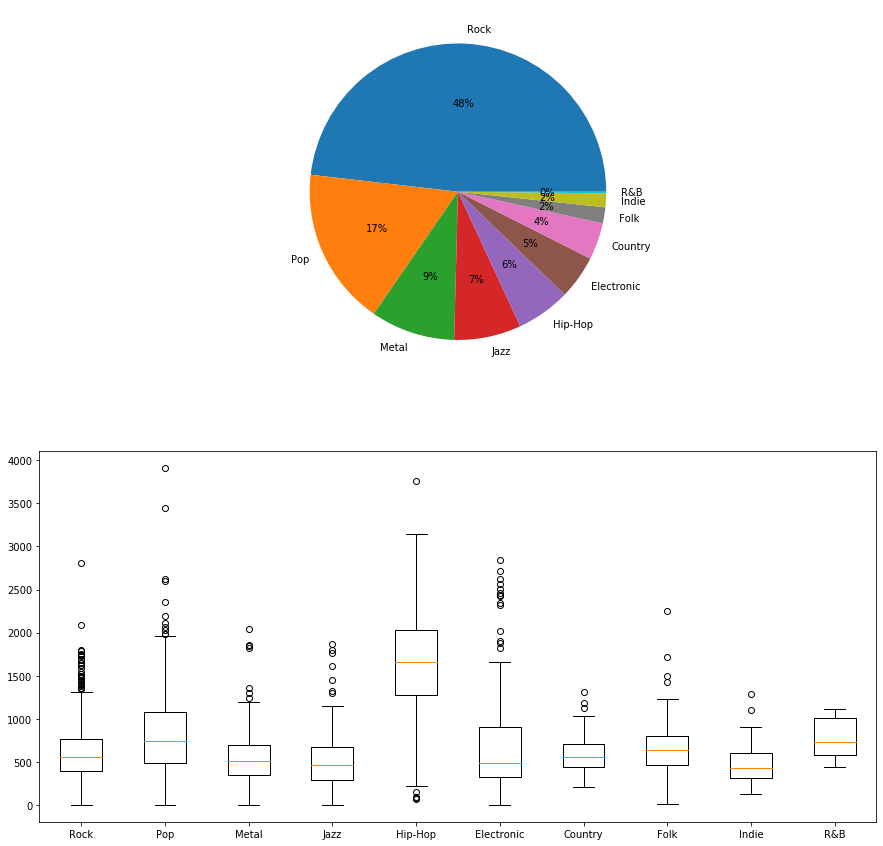

0.1413673232908459


In [ ]:
# Load the data in (if you pass true you only get 5000 data points)
X_train, X_test, y_train, y_test = loadData('lyrics.csv', True) 
# Explore the data through graphs
dataExploration(X_train, y_train)

n_components = 20

# Initial run at cluster and classification comparison
acc_class = classifierComparison(X_train, X_test, y_train, y_test, n_components)
acc_clust = clusterComparison(X_train, X_test, y_train, y_test, n_components)


### Structure data for evaluation:

In [ ]:
genre_counts = y_train.value_counts()
labels = list(genre_counts.index)
#tf_class_svm = [[],[],[],[],[],[],[],[],[],[]]
#wv_class_svm = [[],[],[],[],[],[],[],[],[],[]]
tf_class_knn = [[],[],[],[],[],[],[],[],[],[]]
wv_class_knn = [[],[],[],[],[],[],[],[],[],[]]
tf_class_nn = [[],[],[],[],[],[],[],[],[],[]]
wv_class_nn = [[],[],[],[],[],[],[],[],[],[]]

tf_clust_kmeans = [[],[],[],[],[],[],[],[],[],[]]
tf_clust_spect = [[],[],[],[],[],[],[],[],[],[]]
wv_clust_kmeans = [[],[],[],[],[],[],[],[],[],[]]
wv_clust_spect = [[],[],[],[],[],[],[],[],[],[]]

#for i, row in acc_class[0].iterrows():
#    tf_class_svm[labels.index(acc_class[0].loc[i,'Genre'])].append(acc_class[0].loc[i,'Cluster'])
for i, row in acc_class[1].iterrows():
    tf_class_knn[labels.index(acc_class[1].loc[i,'Genre'])].append(acc_class[1].loc[i,'Cluster'])
for i, row in acc_class[2].iterrows():
    tf_class_nn[labels.index(acc_class[2].loc[i,'Genre'])].append(acc_class[2].loc[i,'Cluster'])
#for i, row in acc_class[3].iterrows():
#    wv_class_svm[labels.index(acc_class[3].loc[i,'Genre'])].append(acc_class[3].loc[i,'Cluster'])
for i, row in acc_class[4].iterrows():
    wv_class_knn[labels.index(acc_class[4].loc[i,'Genre'])].append(acc_class[4].loc[i,'Cluster'])
for i, row in acc_class[5].iterrows():
    wv_class_nn[labels.index(acc_class[5].loc[i,'Genre'])].append(acc_class[5].loc[i,'Cluster'])

    
for i, row in acc_clust[0].iterrows():
    tf_clust_kmeans[labels.index(acc_clust[0].loc[i,'Genre'])].append(acc_clust[0].loc[i,'Cluster'])
for i, row in acc_clust[1].iterrows():  
    tf_clust_spect[labels.index(acc_clust[1].loc[i,'Genre'])].append(acc_clust[1].loc[i,'Cluster'])
for i, row in acc_clust[2].iterrows():
    wv_clust_kmeans[labels.index(acc_clust[2].loc[i,'Genre'])].append(acc_clust[2].loc[i,'Cluster'])
for i, row in acc_clust[3].iterrows():  
    wv_clust_spect[labels.index(acc_clust[3].loc[i,'Genre'])].append(acc_clust[3].loc[i,'Cluster'])


### External Evaluation of Clusterd data:

In [ ]:
for i in range(len(labels)):
    print(labels[i])
    #kmeans
    plt.subplot(1, 2, 1)
    label, counts = np.unique(wv_clust_kmeans[i], return_counts=True)
    plt.bar(label, counts, align='center', alpha=0.5, color="purple", label="Word2Vec k-means")
    label, counts = np.unique(tf_clust_kmeans[i], return_counts=True)
    plt.bar(label, counts, align='center', alpha=0.5, color="gray", label="TFIDF kmeans")
    plt.legend(loc='upper right')
    plt.xticks(range(len(labels)))
    plt.xlim([-1, len(labels)])
    # spect
    plt.subplot(1, 2, 2)
    label, counts = np.unique(wv_clust_spect[i], return_counts=True)
    plt.bar(label, counts, align='center', alpha=0.5, color="purple", label="Word2Vec spectral")
    label, counts = np.unique(tf_clust_spect[i], return_counts=True)
    plt.bar(label, counts, align='center', alpha=0.5, color="gray", label="TFIDF spectral")
    plt.legend(loc='upper right')
    plt.xticks(range(len(labels)))
    plt.xlim([-1, len(labels)])
    plt.show()
    


### Evaluation of classification data:

In [ ]:
for i in range(len(labels)):
    print(labels[i])
    #knn
    plt.subplot(1, 2, 1)
    label, counts = np.unique(wv_class_knn[i], return_counts=True)
    plt.bar(label, counts, align='center', alpha=0.5, color="purple", label="Word2Vec knn")
    label, counts = np.unique(tf_class_knn[i], return_counts=True)
    plt.bar(label, counts, align='center', alpha=0.5, color="gray", label="TFIDF knn")
    plt.legend(loc='upper right')
    #nn
    plt.subplot(1, 2, 2)
    label, counts = np.unique(wv_class_nn[i], return_counts=True)
    plt.bar(label, counts, align='center', alpha=0.5, color="purple", label="Word2Vec nn")
    label, counts = np.unique(tf_class_nn[i], return_counts=True)
    plt.bar(label, counts, align='center', alpha=0.5, color="gray", label="TFIDF nn")
    plt.legend(loc='upper right')
    plt.show()
            

### Final Evaluation of hypertuned Models

In [ ]:
# Hypertune params
# Don't run unless you have 3 hours to waist 
hypertune_nn(X_train, X_test, y_train, y_test, n_components)
 

### Final Analysis of MLP and TF-IDF

In [ ]:
# Final analysis of mpl and tfidf
genre_counts = y_train.value_counts()
labels = list(genre_counts.index)
final_acc = nn(X_train, X_test, y_train, y_test, labels) 

# each column is the correct genre, and each row is what the song was actually labed
genre_class = [[],[],[],[],[],[],[],[],[],[]]

for i, row in final_acc.iterrows():
    genre_class[labels.index(final_acc.loc[i,'Genre'])].append(final_acc.loc[i,'Cluster'])

for i in range(len(labels)):
    print(labels[i])
    label, counts = np.unique(genre_class[i], return_counts=True)
    plt.bar(label, counts, align='center', alpha=0.5, color="purple")
    plt.show()
            